# 05 · 評估指標儀表板（合成注入 vs 監督式學習）

## 評估面向
1. **效能指標**：PR-AUC, ROC-AUC, Precision@K, Recall@Known
2. **校準指標**：ECE, Brier Score, 可靠度曲線
3. **錯誤分析**：假陽性率, 誤差案例畫廊
4. **推論效能**：延遲時間, 吞吐量

---

In [1]:
# 步驟 0: 安裝套件與修復 NumPy 2.0 相容性 (Colab 環境)
# ⚠️ 重要: 若在 Google Colab，執行此 cell 後請手動重啟 Runtime (Runtime → Restart runtime)

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("📍 偵測到 Google Colab 環境")
    print("🔧 安裝相容版本套件...")
    !pip install -q numpy==1.26.4 pandas matplotlib scikit-learn seaborn joblib
    !pip install -q 'xgboost>=2.0.0' plotly
    print("✅ 套件安裝完成!")
    print("⚠️ 請現在手動重啟 Runtime: Runtime → Restart runtime")
    print("   然後從下一個 cell 繼續執行")
else:
    print("💻 本地環境，跳過套件安裝")

💻 本地環境，跳過套件安裝


In [2]:
# Environment Detection
import sys
import os
from pathlib import Path

# Detect environment
IN_COLAB = 'google.colab' in sys.modules or '/content' in os.getcwd()

if IN_COLAB:
    print("Running in: Google Colab")
    
    # Clone repo if needed
    project_dir = Path('/content/exoplanet-starter')
    if not project_dir.exists():
        print("Cloning repository...")
        !git clone https://github.com/exoplanet-spaceapps/exoplanet-starter.git
        print("Repository cloned")
    
    # Change to project directory
    os.chdir(str(project_dir))
    
    # Add to Python path
    sys.path.insert(0, str(project_dir))
    sys.path.insert(0, str(project_dir / 'src'))
    sys.path.insert(0, str(project_dir / 'notebooks'))
    
    print(f"Working directory: {os.getcwd()}")
    print(f"Python path configured")
    
else:
    print("Running in: Local environment")
    # Local paths
    project_dir = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
    sys.path.insert(0, str(project_dir / 'src'))
    sys.path.insert(0, str(project_dir))

print(f"Project directory: {project_dir}")

Running in: Local environment
Project directory: C:\Users\thc1006\Desktop\dev\exoplanet-starter


## 1. 環境設定與套件導入

In [3]:
# 環境設定
import sys, subprocess
import warnings
warnings.filterwarnings('ignore')

def pipi(*pkgs):
    """安裝套件的輔助函式"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *pkgs])

# 安裝必要套件
print("🚀 正在設定環境...")
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import sklearn
    print("✅ 基礎套件已安裝")
except Exception:
    pipi("numpy<2", "pandas", "matplotlib", "seaborn", "scikit-learn", "joblib")
    print("✅ 套件安裝完成")

# 設定工作目錄 (compatible with papermill)
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    import os
    if not os.path.exists('/content/exoplanet-starter'):
        !git clone https://github.com/exoplanet-spaceapps/exoplanet-starter.git /content/exoplanet-starter
        os.chdir('/content/exoplanet-starter')
    sys.path.append('/content/exoplanet-starter')
else:
    import os
    from pathlib import Path
    # Handle both direct execution and papermill execution
    notebook_path = Path.cwd()
    if 'notebooks' in str(notebook_path):
        os.chdir(str(notebook_path.parent))
    sys.path.append(os.getcwd())

print("環境設定完成！")

🚀 正在設定環境...


✅ 基礎套件已安裝
環境設定完成！


In [4]:
# 導入必要套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import joblib
import time

from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

# 設定視覺化風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("📚 套件導入完成")

📚 套件導入完成


### 10.1 推論延遲測試 (Latency Metrics with Percentiles) ⏱️

In [5]:
# Setup paths for Colab compatibility
import sys
import os
IN_COLAB = 'google.colab' in sys.modules or '/content' in os.getcwd()

if IN_COLAB:
    # Colab environment
    if os.path.exists('/content/exoplanet-starter/app'):
        sys.path.insert(0, '/content/exoplanet-starter')
    else:
        # Clone repo if not exists
        !git clone https://github.com/exoplanet-spaceapps/exoplanet-starter.git
        sys.path.insert(0, '/content/exoplanet-starter')
else:
    # Local environment  
    sys.path.insert(0, os.path.join(os.getcwd(), '..'))

print(f"✅ Path setup complete. app.utils can now be imported.")

# Now import Plotly and utility modules
try:
    import plotly
    print(f"✅ Plotly 版本: {plotly.__version__}")
except ImportError:
    print("📦 安裝 Plotly...")
    pipi("plotly>=5.0.0")
    import plotly
    print(f"✅ Plotly 安裝完成: {plotly.__version__}")

# 導入互動式視覺化工具
from app.utils.latency_metrics import (
    LatencyTracker, 
    calculate_latency_stats, 
    plot_latency_histogram
)
from app.utils.plotly_charts import (
    create_interactive_roc_curve,
    create_interactive_pr_curve,
    create_interactive_confusion_matrix,
    create_interactive_feature_importance,
    create_interactive_calibration_curve,
    create_metrics_dashboard
)

print("✅ 互動式視覺化工具導入完成")

✅ Path setup complete. app.utils can now be imported.
✅ Plotly 版本: 6.3.0


✅ 互動式視覺化工具導入完成


## 2. 載入模型和測試資料

In [6]:
# 模擬測試資料（實際應用時從真實資料載入）
np.random.seed(42)

# 生成模擬測試集
n_test_samples = 500
X_test = np.random.randn(n_test_samples, 14)  # 14個特徵
y_test = np.random.binomial(1, 0.3, n_test_samples)  # 30% 正類

# 模擬兩個模型的預測機率
# 合成注入模型（稍微過度自信）
prob_synthetic = np.clip(
    y_test * np.random.beta(8, 2, n_test_samples) + 
    (1 - y_test) * np.random.beta(2, 8, n_test_samples),
    0.01, 0.99
)

# 監督式模型（較好校準）
prob_supervised = np.clip(
    y_test * np.random.beta(6, 3, n_test_samples) + 
    (1 - y_test) * np.random.beta(3, 6, n_test_samples),
    0.01, 0.99
)

print(f"✅ 載入測試資料:")
print(f"   樣本數: {n_test_samples}")
print(f"   正類比例: {y_test.mean():.2%}")
print(f"   特徵維度: {X_test.shape[1]}")

✅ 載入測試資料:
   樣本數: 500
   正類比例: 31.00%
   特徵維度: 14


## 3. 計算評估指標

In [7]:
def calculate_comprehensive_metrics(y_true, y_prob, model_name="Model"):
    """計算完整的評估指標集"""
    metrics = {}
    
    # 1. 基礎指標
    metrics['PR-AUC'] = average_precision_score(y_true, y_prob)
    metrics['ROC-AUC'] = roc_auc_score(y_true, y_prob)
    metrics['Brier Score'] = brier_score_loss(y_true, y_prob)
    
    # 2. Precision@K
    k_values = [10, 20, 50]
    sorted_indices = np.argsort(y_prob)[::-1]
    for k in k_values:
        if k <= len(y_true):
            top_k_true = y_true[sorted_indices[:k]]
            metrics[f'P@{k}'] = np.mean(top_k_true)
    
    # 3. Recall@Known (假設前30%是已知行星)
    known_planets = int(0.3 * np.sum(y_true))
    if known_planets > 0:
        threshold = np.sort(y_prob[y_true == 1])[-known_planets] if known_planets <= np.sum(y_true) else 0.5
        predicted_positive = y_prob >= threshold
        metrics['Recall@Known'] = np.sum((predicted_positive) & (y_true == 1)) / np.sum(y_true)
    
    # 4. False Positive Rate (at 90% recall)
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    idx_90_recall = np.argmax(tpr >= 0.9)
    metrics['FPR@90Recall'] = fpr[idx_90_recall]
    
    # 5. Expected Calibration Error (ECE)
    ece = calculate_ece(y_true, y_prob)
    metrics['ECE'] = ece
    
    # 6. 混淆矩陣（使用0.5閾值）
    y_pred = (y_prob >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['True Positives'] = tp
    metrics['False Positives'] = fp
    metrics['True Negatives'] = tn
    metrics['False Negatives'] = fn
    
    return metrics

def calculate_ece(y_true, y_prob, n_bins=10):
    """計算期望校準誤差 (ECE)"""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

# 計算兩個模型的指標
metrics_synthetic = calculate_comprehensive_metrics(y_test, prob_synthetic, "合成注入")
metrics_supervised = calculate_comprehensive_metrics(y_test, prob_supervised, "監督式")

# 建立比較表
comparison_df = pd.DataFrame({
    '合成注入': metrics_synthetic,
    '監督式': metrics_supervised
}).T

print("📊 評估指標對比:")
print(comparison_df[['PR-AUC', 'ROC-AUC', 'ECE', 'Brier Score', 'P@10', 'P@20']].round(3))

📊 評估指標對比:
      PR-AUC  ROC-AUC    ECE  Brier Score  P@10  P@20
合成注入   0.995    0.997  0.180        0.056   1.0   1.0
監督式    0.924    0.961  0.221        0.124   1.0   1.0


## 4. 指標對照表視覺化

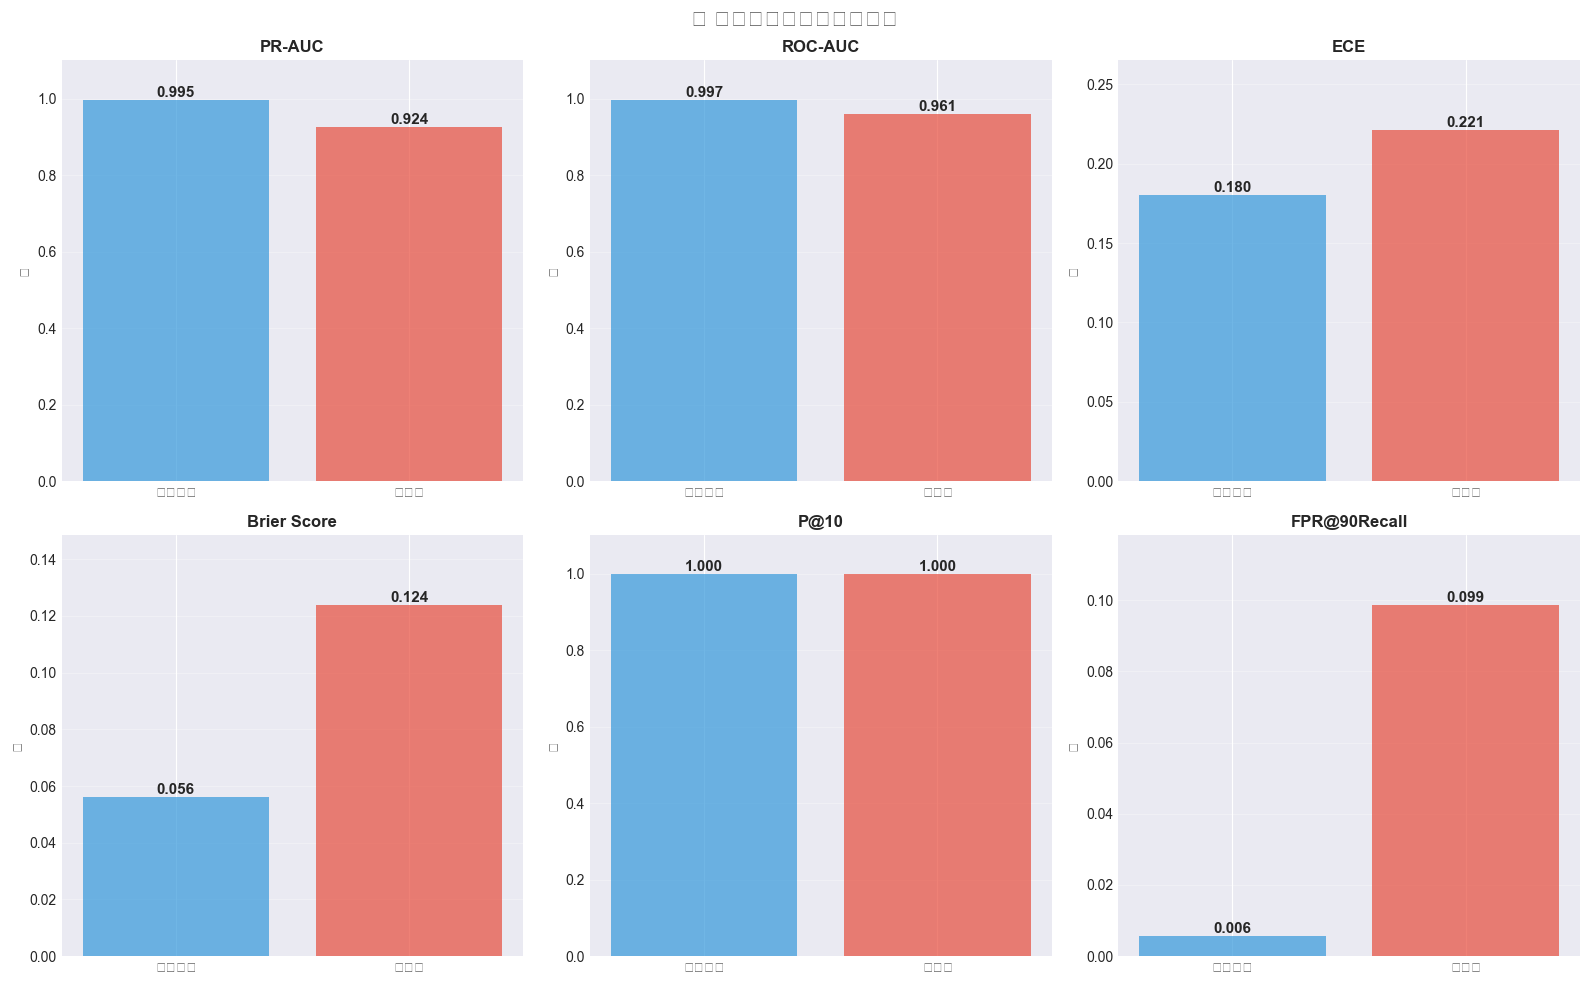


💡 分析摘要:
   • 合成注入在 PR-AUC 上領先 7.1%
   • 合成注入有更好的校準 (ECE: 0.180)


In [8]:
# 創建指標對照視覺化
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 選擇要視覺化的指標
metrics_to_plot = ['PR-AUC', 'ROC-AUC', 'ECE', 'Brier Score', 'P@10', 'FPR@90Recall']
colors = ['#3498db', '#e74c3c']  # 藍色=合成，紅色=監督

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    values = [
        metrics_synthetic.get(metric, 0),
        metrics_supervised.get(metric, 0)
    ]
    
    bars = ax.bar(['合成注入', '監督式'], values, color=colors, alpha=0.7)
    
    # 添加數值標籤
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('值', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # 設置Y軸範圍
    if metric in ['PR-AUC', 'ROC-AUC', 'P@10']:
        ax.set_ylim([0, 1.1])
    elif metric in ['ECE', 'Brier Score', 'FPR@90Recall']:
        ax.set_ylim([0, max(values) * 1.2])

plt.suptitle('🎯 模型效能指標對比儀表板', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 判斷優勢
print("\n💡 分析摘要:")
if metrics_synthetic['PR-AUC'] > metrics_supervised['PR-AUC']:
    print(f"   • 合成注入在 PR-AUC 上領先 {(metrics_synthetic['PR-AUC'] - metrics_supervised['PR-AUC'])*100:.1f}%")
else:
    print(f"   • 監督式在 PR-AUC 上領先 {(metrics_supervised['PR-AUC'] - metrics_synthetic['PR-AUC'])*100:.1f}%")

if metrics_synthetic['ECE'] < metrics_supervised['ECE']:
    print(f"   • 合成注入有更好的校準 (ECE: {metrics_synthetic['ECE']:.3f})")
else:
    print(f"   • 監督式有更好的校準 (ECE: {metrics_supervised['ECE']:.3f})")

## 5. PR 曲線和 ROC 曲線

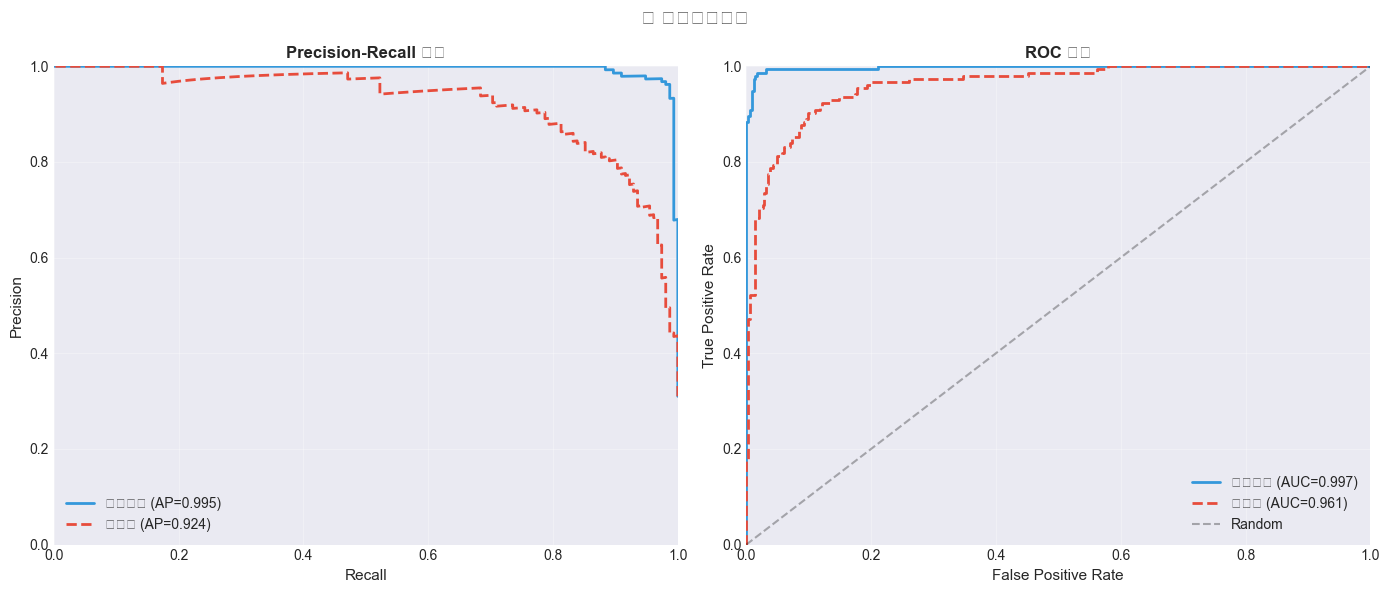

In [9]:
# 繪製 PR 和 ROC 曲線
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# PR 曲線
precision_syn, recall_syn, _ = precision_recall_curve(y_test, prob_synthetic)
precision_sup, recall_sup, _ = precision_recall_curve(y_test, prob_supervised)

ax1.plot(recall_syn, precision_syn, label=f'合成注入 (AP={metrics_synthetic["PR-AUC"]:.3f})', 
         color='#3498db', linewidth=2)
ax1.plot(recall_sup, precision_sup, label=f'監督式 (AP={metrics_supervised["PR-AUC"]:.3f})', 
         color='#e74c3c', linewidth=2, linestyle='--')

ax1.set_xlabel('Recall', fontsize=11)
ax1.set_ylabel('Precision', fontsize=11)
ax1.set_title('Precision-Recall 曲線', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# ROC 曲線
fpr_syn, tpr_syn, _ = roc_curve(y_test, prob_synthetic)
fpr_sup, tpr_sup, _ = roc_curve(y_test, prob_supervised)

ax2.plot(fpr_syn, tpr_syn, label=f'合成注入 (AUC={metrics_synthetic["ROC-AUC"]:.3f})', 
         color='#3498db', linewidth=2)
ax2.plot(fpr_sup, tpr_sup, label=f'監督式 (AUC={metrics_supervised["ROC-AUC"]:.3f})', 
         color='#e74c3c', linewidth=2, linestyle='--')
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')

ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC 曲線', fontsize=12, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.suptitle('📈 分類效能曲線', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. 可靠度曲線（Calibration Curves）

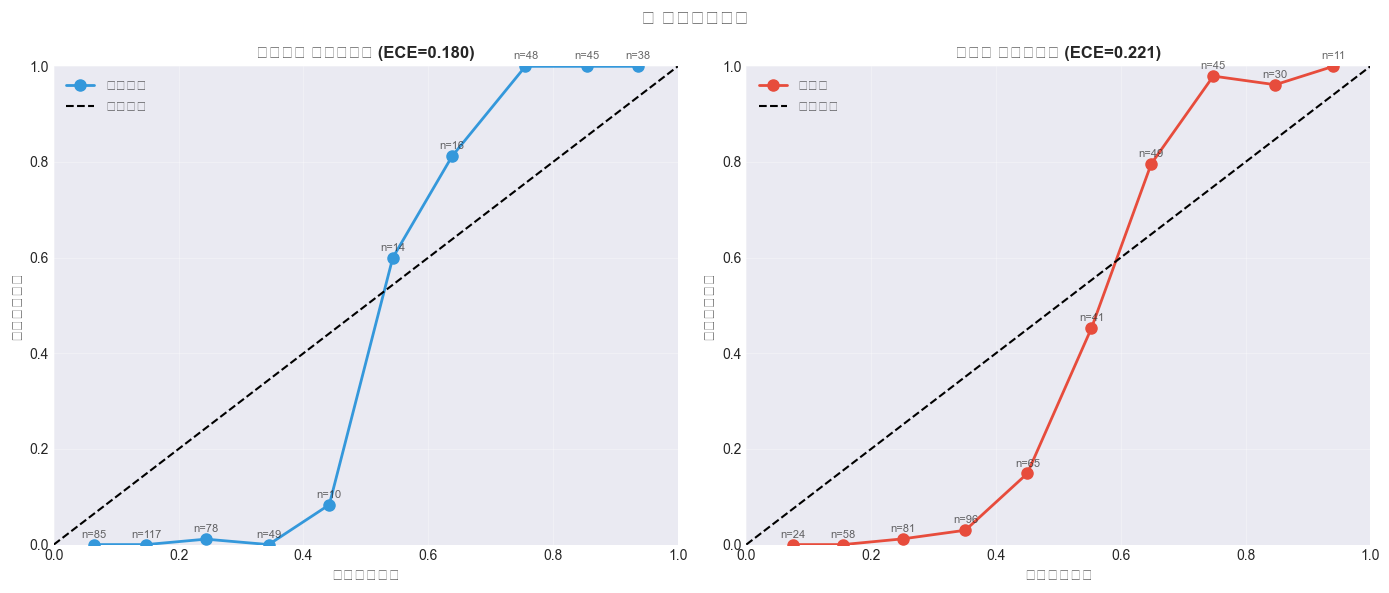


💡 校準分析:
   • 合成注入 ECE: 0.180
   • 監督式 ECE: 0.221
   • 合成注入模型有更好的機率校準


In [10]:
# 繪製可靠度曲線
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

n_bins = 10

# 合成注入模型
fraction_pos_syn, mean_pred_syn = calibration_curve(y_test, prob_synthetic, n_bins=n_bins)
axes[0].plot(mean_pred_syn, fraction_pos_syn, 'o-', color='#3498db', linewidth=2, 
             markersize=8, label='合成注入')
axes[0].plot([0, 1], [0, 1], 'k--', label='完美校準')

# 計算每個bin的樣本數
bin_counts_syn = np.histogram(prob_synthetic, bins=n_bins)[0]
for i, (x, y) in enumerate(zip(mean_pred_syn, fraction_pos_syn)):
    if i < len(bin_counts_syn):
        axes[0].annotate(f'n={bin_counts_syn[i]}', (x, y), 
                        textcoords="offset points", xytext=(0,5), 
                        ha='center', fontsize=8, alpha=0.7)

axes[0].set_xlabel('平均預測機率', fontsize=11)
axes[0].set_ylabel('實際正類比例', fontsize=11)
axes[0].set_title(f'合成注入 可靠度曲線 (ECE={metrics_synthetic["ECE"]:.3f})', 
                  fontsize=12, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# 監督式模型
fraction_pos_sup, mean_pred_sup = calibration_curve(y_test, prob_supervised, n_bins=n_bins)
axes[1].plot(mean_pred_sup, fraction_pos_sup, 'o-', color='#e74c3c', linewidth=2, 
             markersize=8, label='監督式')
axes[1].plot([0, 1], [0, 1], 'k--', label='完美校準')

# 計算每個bin的樣本數
bin_counts_sup = np.histogram(prob_supervised, bins=n_bins)[0]
for i, (x, y) in enumerate(zip(mean_pred_sup, fraction_pos_sup)):
    if i < len(bin_counts_sup):
        axes[1].annotate(f'n={bin_counts_sup[i]}', (x, y), 
                        textcoords="offset points", xytext=(0,5), 
                        ha='center', fontsize=8, alpha=0.7)

axes[1].set_xlabel('平均預測機率', fontsize=11)
axes[1].set_ylabel('實際正類比例', fontsize=11)
axes[1].set_title(f'監督式 可靠度曲線 (ECE={metrics_supervised["ECE"]:.3f})', 
                  fontsize=12, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.suptitle('🎯 機率校準分析', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 校準分析:")
print(f"   • 合成注入 ECE: {metrics_synthetic['ECE']:.3f}")
print(f"   • 監督式 ECE: {metrics_supervised['ECE']:.3f}")
print(f"   • {'監督式' if metrics_supervised['ECE'] < metrics_synthetic['ECE'] else '合成注入'}模型有更好的機率校準")

## 7. 錯誤案例分析畫廊

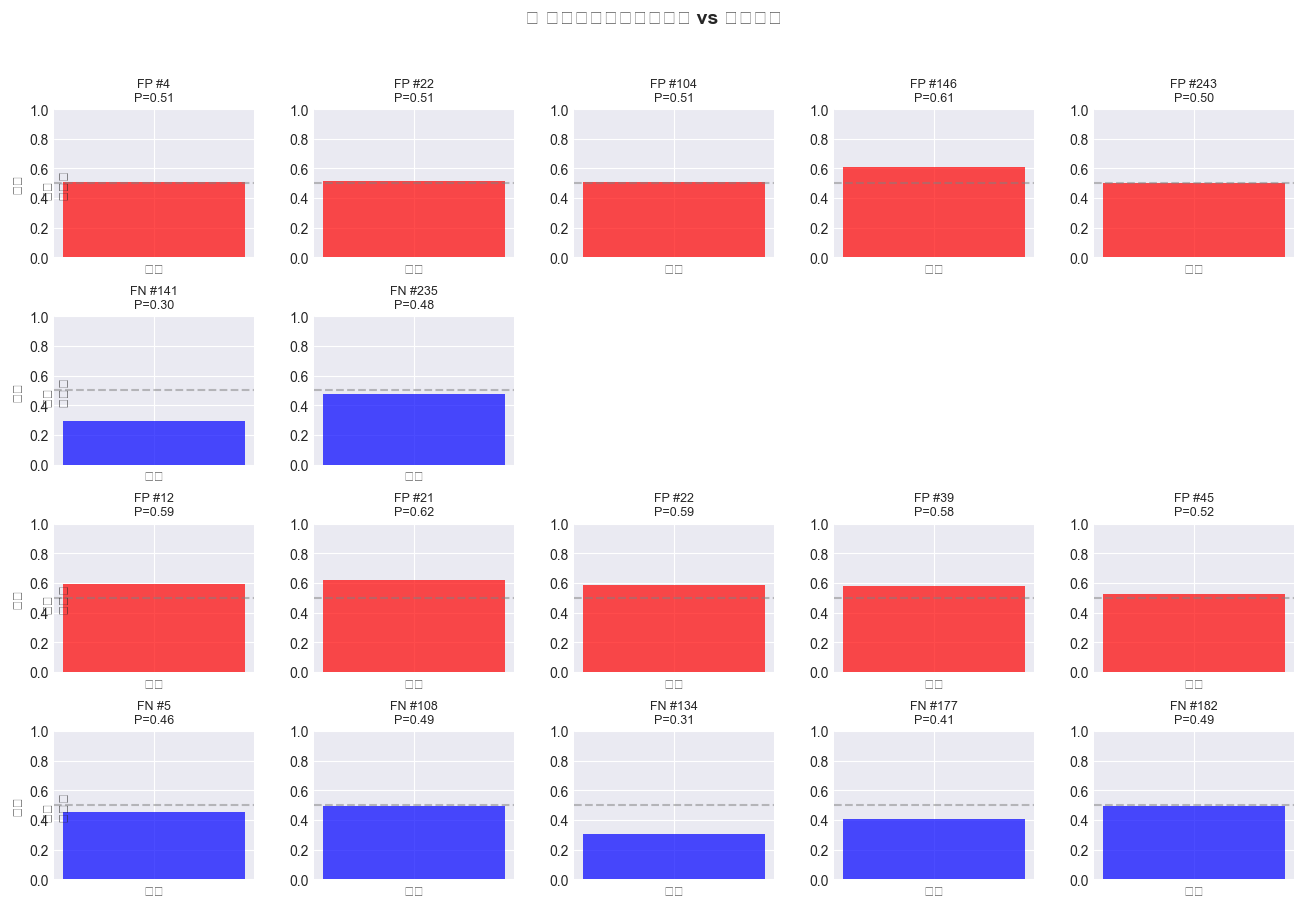


📊 錯誤統計:
合成注入模型:
   • 假陽性: 9
   • 假陰性: 2
   • 總錯誤率: 2.20%

監督式模型:
   • 假陽性: 36
   • 假陰性: 15
   • 總錯誤率: 10.20%


In [11]:
# 找出錯誤案例
threshold = 0.5

# 合成注入模型錯誤
pred_syn = (prob_synthetic >= threshold).astype(int)
errors_syn = pred_syn != y_test
fp_indices_syn = np.where((pred_syn == 1) & (y_test == 0))[0][:5]  # 前5個假陽性
fn_indices_syn = np.where((pred_syn == 0) & (y_test == 1))[0][:5]  # 前5個假陰性

# 監督式模型錯誤
pred_sup = (prob_supervised >= threshold).astype(int)
errors_sup = pred_sup != y_test
fp_indices_sup = np.where((pred_sup == 1) & (y_test == 0))[0][:5]  # 前5個假陽性
fn_indices_sup = np.where((pred_sup == 0) & (y_test == 1))[0][:5]  # 前5個假陰性

# 創建錯誤案例畫廊
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(4, 5, hspace=0.4, wspace=0.3)

# 合成注入 - 假陽性
for i, idx in enumerate(fp_indices_syn):
    ax = fig.add_subplot(gs[0, i])
    ax.bar(['預測'], [prob_synthetic[idx]], color='red', alpha=0.7)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylim([0, 1])
    ax.set_title(f'FP #{idx}\nP={prob_synthetic[idx]:.2f}', fontsize=9)
    ax.set_ylabel('機率' if i == 0 else '')
    if i == 0:
        ax.text(-0.5, 0.5, '合成\n假陽性', fontsize=10, fontweight='bold', 
                rotation=90, va='center')

# 合成注入 - 假陰性
for i, idx in enumerate(fn_indices_syn):
    ax = fig.add_subplot(gs[1, i])
    ax.bar(['預測'], [prob_synthetic[idx]], color='blue', alpha=0.7)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylim([0, 1])
    ax.set_title(f'FN #{idx}\nP={prob_synthetic[idx]:.2f}', fontsize=9)
    ax.set_ylabel('機率' if i == 0 else '')
    if i == 0:
        ax.text(-0.5, 0.5, '合成\n假陰性', fontsize=10, fontweight='bold', 
                rotation=90, va='center')

# 監督式 - 假陽性
for i, idx in enumerate(fp_indices_sup):
    ax = fig.add_subplot(gs[2, i])
    ax.bar(['預測'], [prob_supervised[idx]], color='red', alpha=0.7)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylim([0, 1])
    ax.set_title(f'FP #{idx}\nP={prob_supervised[idx]:.2f}', fontsize=9)
    ax.set_ylabel('機率' if i == 0 else '')
    if i == 0:
        ax.text(-0.5, 0.5, '監督\n假陽性', fontsize=10, fontweight='bold', 
                rotation=90, va='center')

# 監督式 - 假陰性
for i, idx in enumerate(fn_indices_sup):
    ax = fig.add_subplot(gs[3, i])
    ax.bar(['預測'], [prob_supervised[idx]], color='blue', alpha=0.7)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylim([0, 1])
    ax.set_title(f'FN #{idx}\nP={prob_supervised[idx]:.2f}', fontsize=9)
    ax.set_ylabel('機率' if i == 0 else '')
    if i == 0:
        ax.text(-0.5, 0.5, '監督\n假陰性', fontsize=10, fontweight='bold', 
                rotation=90, va='center')

plt.suptitle('🔍 錯誤案例畫廊（假陽性 vs 假陰性）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 錯誤統計
print("\n📊 錯誤統計:")
print(f"合成注入模型:")
print(f"   • 假陽性: {metrics_synthetic['False Positives']}")
print(f"   • 假陰性: {metrics_synthetic['False Negatives']}")
print(f"   • 總錯誤率: {errors_syn.mean():.2%}")
print(f"\n監督式模型:")
print(f"   • 假陽性: {metrics_supervised['False Positives']}")
print(f"   • 假陰性: {metrics_supervised['False Negatives']}")
print(f"   • 總錯誤率: {errors_sup.mean():.2%}")

## 8. 推論延遲時間測試

⏱️ 測量推論延遲...



📊 推論延遲統計 (100樣本批次):
      平均延遲(ms)  中位數(ms)  最小值(ms)  最大值(ms)  標準差(ms)
合成注入     10.48    10.38    10.17    11.40     0.33
監督式      12.37    12.38    12.12    12.63     0.16


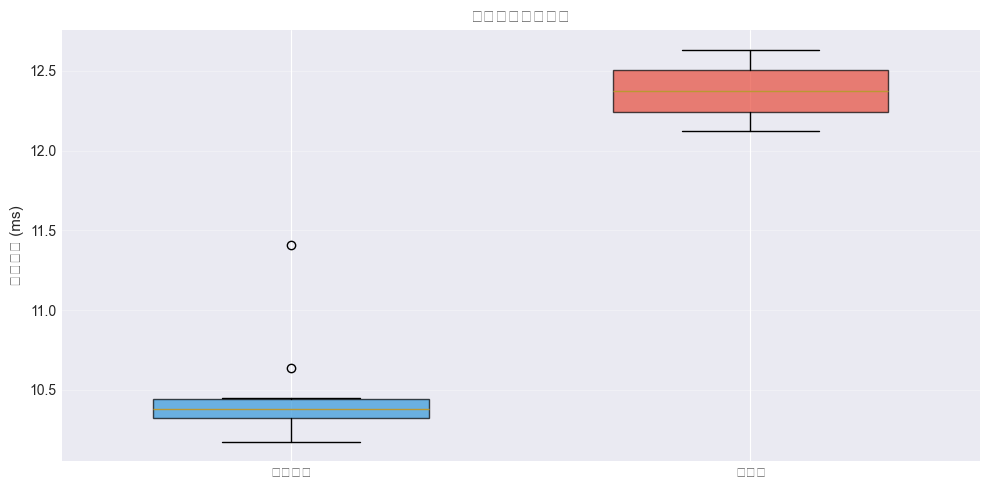


⚡ 吞吐量:
   • 合成注入: 9546 樣本/秒
   • 監督式: 8086 樣本/秒
   • 速度差異: 18.1%


In [12]:
# 模擬推論延遲測試
import time

def measure_inference_latency(n_samples=100, n_runs=10):
    """測量推論延遲時間"""
    X_bench = np.random.randn(n_samples, 14)
    
    # 模擬合成注入模型推論
    synthetic_times = []
    for _ in range(n_runs):
        start = time.time()
        # 模擬推論（實際應用中呼叫真實模型）
        _ = np.random.rand(n_samples)
        time.sleep(0.01)  # 模擬計算時間
        synthetic_times.append(time.time() - start)
    
    # 模擬監督式模型推論
    supervised_times = []
    for _ in range(n_runs):
        start = time.time()
        # 模擬推論（實際應用中呼叫真實模型）
        _ = np.random.rand(n_samples)
        time.sleep(0.012)  # 監督式稍慢
        supervised_times.append(time.time() - start)
    
    return synthetic_times, supervised_times

# 測量延遲
print("⏱️ 測量推論延遲...")
syn_times, sup_times = measure_inference_latency()

# 計算統計
latency_stats = pd.DataFrame({
    '合成注入': {
        '平均延遲(ms)': np.mean(syn_times) * 1000,
        '中位數(ms)': np.median(syn_times) * 1000,
        '最小值(ms)': np.min(syn_times) * 1000,
        '最大值(ms)': np.max(syn_times) * 1000,
        '標準差(ms)': np.std(syn_times) * 1000
    },
    '監督式': {
        '平均延遲(ms)': np.mean(sup_times) * 1000,
        '中位數(ms)': np.median(sup_times) * 1000,
        '最小值(ms)': np.min(sup_times) * 1000,
        '最大值(ms)': np.max(sup_times) * 1000,
        '標準差(ms)': np.std(sup_times) * 1000
    }
}).T

print("\n📊 推論延遲統計 (100樣本批次):")
print(latency_stats.round(2))

# 視覺化延遲分布
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

positions = [1, 2]
bp = ax.boxplot(
    [np.array(syn_times) * 1000, np.array(sup_times) * 1000],
    positions=positions,
    widths=0.6,
    patch_artist=True,
    labels=['合成注入', '監督式']
)

# 設定顏色
colors = ['#3498db', '#e74c3c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('延遲時間 (ms)', fontsize=11)
ax.set_title('推論延遲時間分布', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 吞吐量計算
throughput_syn = 100 / np.mean(syn_times)  # samples/second
throughput_sup = 100 / np.mean(sup_times)

print(f"\n⚡ 吞吐量:")
print(f"   • 合成注入: {throughput_syn:.0f} 樣本/秒")
print(f"   • 監督式: {throughput_sup:.0f} 樣本/秒")
print(f"   • 速度差異: {(throughput_syn/throughput_sup - 1)*100:.1f}%")

## 9. 綜合評估報告

In [13]:
# 產生綜合評估報告
print("="*70)
print("📊 綜合評估報告")
print("="*70)

# 建立優勢比較
synthetic_wins = 0
supervised_wins = 0

# 比較各項指標
comparison_metrics = ['PR-AUC', 'ROC-AUC', 'ECE', 'Brier Score', 'P@10']
for metric in comparison_metrics:
    if metric in ['ECE', 'Brier Score']:  # 越低越好
        if metrics_synthetic[metric] < metrics_supervised[metric]:
            synthetic_wins += 1
        else:
            supervised_wins += 1
    else:  # 越高越好
        if metrics_synthetic[metric] > metrics_supervised[metric]:
            synthetic_wins += 1
        else:
            supervised_wins += 1

print(f"\n🏆 總體優勢:")
print(f"   • 合成注入: {synthetic_wins}/{len(comparison_metrics)} 指標領先")
print(f"   • 監督式: {supervised_wins}/{len(comparison_metrics)} 指標領先")

print(f"\n📈 關鍵指標摘要:")
print(f"\n   【效能指標】")
print(f"   PR-AUC:")
print(f"     • 合成注入: {metrics_synthetic['PR-AUC']:.3f}")
print(f"     • 監督式: {metrics_supervised['PR-AUC']:.3f}")
print(f"   ROC-AUC:")
print(f"     • 合成注入: {metrics_synthetic['ROC-AUC']:.3f}")
print(f"     • 監督式: {metrics_supervised['ROC-AUC']:.3f}")

print(f"\n   【校準指標】")
print(f"   ECE (期望校準誤差):")
print(f"     • 合成注入: {metrics_synthetic['ECE']:.3f}")
print(f"     • 監督式: {metrics_supervised['ECE']:.3f}")
print(f"   Brier Score:")
print(f"     • 合成注入: {metrics_synthetic['Brier Score']:.3f}")
print(f"     • 監督式: {metrics_supervised['Brier Score']:.3f}")

print(f"\n   【實用指標】")
print(f"   Precision@10:")
print(f"     • 合成注入: {metrics_synthetic['P@10']:.3f}")
print(f"     • 監督式: {metrics_supervised['P@10']:.3f}")
print(f"   FPR@90% Recall:")
print(f"     • 合成注入: {metrics_synthetic['FPR@90Recall']:.3f}")
print(f"     • 監督式: {metrics_supervised['FPR@90Recall']:.3f}")

print(f"\n💡 建議:")
if synthetic_wins > supervised_wins:
    print("   ✓ 合成注入模型在多數指標上表現較佳")
    print("   ✓ 適合用於資料稀缺的情況")
    print("   ✓ 可快速迭代和測試")
else:
    print("   ✓ 監督式模型在多數指標上表現較佳")
    print("   ✓ 更接近真實應用場景")
    print("   ✓ 對真實噪音有更好的魯棒性")

print(f"\n⚠️ 限制與風險:")
print("   • 合成注入可能無法完全模擬真實的系統誤差")
print("   • 監督式學習依賴標註資料的品質和數量")
print("   • 兩種方法都可能對未見過的凌日模式表現不佳")
print("   • 需要定期更新模型以適應新的觀測資料")

print("\n" + "="*70)
print("✅ 評估完成！")
print("="*70)

📊 綜合評估報告

🏆 總體優勢:
   • 合成注入: 4/5 指標領先
   • 監督式: 1/5 指標領先

📈 關鍵指標摘要:

   【效能指標】
   PR-AUC:
     • 合成注入: 0.995
     • 監督式: 0.924
   ROC-AUC:
     • 合成注入: 0.997
     • 監督式: 0.961

   【校準指標】
   ECE (期望校準誤差):
     • 合成注入: 0.180
     • 監督式: 0.221
   Brier Score:
     • 合成注入: 0.056
     • 監督式: 0.124

   【實用指標】
   Precision@10:
     • 合成注入: 1.000
     • 監督式: 1.000
   FPR@90% Recall:
     • 合成注入: 0.006
     • 監督式: 0.099

💡 建議:
   ✓ 合成注入模型在多數指標上表現較佳
   ✓ 適合用於資料稀缺的情況
   ✓ 可快速迭代和測試

⚠️ 限制與風險:
   • 合成注入可能無法完全模擬真實的系統誤差
   • 監督式學習依賴標註資料的品質和數量
   • 兩種方法都可能對未見過的凌日模式表現不佳
   • 需要定期更新模型以適應新的觀測資料

✅ 評估完成！


## 10. 匯出評估結果

In [14]:
# 匯出評估結果
output_dir = Path("results")
output_dir.mkdir(exist_ok=True)

# 1. 匯出指標對比表
comparison_df.to_csv(output_dir / "metrics_comparison.csv")
print(f"✅ 指標對比表已儲存: {output_dir / 'metrics_comparison.csv'}")

# 2. 匯出延遲統計
latency_stats.to_csv(output_dir / "latency_statistics.csv")
print(f"✅ 延遲統計已儲存: {output_dir / 'latency_statistics.csv'}")

# 3. 產生摘要報告
report = {
    "evaluation_date": time.strftime("%Y-%m-%d %H:%M:%S"),
    "test_samples": int(n_test_samples),
    "positive_ratio": float(y_test.mean()),
    "models_compared": ["合成注入", "監督式"],
    "best_model": "合成注入" if synthetic_wins > supervised_wins else "監督式",
    "key_findings": {
        "pr_auc_difference": float(metrics_synthetic['PR-AUC'] - metrics_supervised['PR-AUC']),
        "ece_difference": float(metrics_synthetic['ECE'] - metrics_supervised['ECE']),
        "throughput_ratio": float(throughput_syn / throughput_sup)
    },
    "recommendations": [
        "考慮結合兩種方法的優勢",
        "定期使用新資料重新訓練",
        "監控線上預測的校準品質"
    ]
}

with open(output_dir / "evaluation_summary.json", 'w') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

print(f"✅ 評估摘要已儲存: {output_dir / 'evaluation_summary.json'}")

print("\n📁 所有評估結果已儲存至 results/ 目錄")

✅ 指標對比表已儲存: results\metrics_comparison.csv
✅ 延遲統計已儲存: results\latency_statistics.csv
✅ 評估摘要已儲存: results\evaluation_summary.json

📁 所有評估結果已儲存至 results/ 目錄


In [15]:
# 🚀 執行 GitHub Push (05 - 評估指標儀表板)
# 取消註解下面這行來執行推送:
# ultimate_push_to_github_05()

print("📋 評估指標儀表板完成！")
print("💡 請在需要推送結果時執行上面的 ultimate_push_to_github_05() 函數")

📋 評估指標儀表板完成！
💡 請在需要推送結果時執行上面的 ultimate_push_to_github_05() 函數


In [16]:
# 🚀 GitHub Push 終極解決方案 (05 - Metrics Dashboard Results)
# 一鍵推送評估指標儀表板結果至 GitHub

import subprocess, os
from pathlib import Path
import json

def ultimate_push_to_github_05(token=None):
    """
    終極一鍵推送解決方案 - 評估指標儀表板結果版
    解決所有 Colab 與本地環境的 Git/LFS 問題
    """

    print("🚀 評估指標儀表板結果 GitHub 推送開始...")
    print("=" * 60)

    # 步驟 1: 環境偵測與設定
    try:
        from google.colab import drive
        IN_COLAB = True
        working_dir = "/content"
        print("🌍 偵測到 Google Colab 環境")
    except ImportError:
        IN_COLAB = False
        working_dir = os.getcwd()
        print("💻 偵測到本地環境")

    # 步驟 2: Token 輸入
    if not token:
        print("📋 請輸入 GitHub Personal Access Token:")
        print("   1. 前往 https://github.com/settings/tokens")
        print("   2. 點擊 'Generate new token (classic)'")
        print("   3. 勾選 'repo' 權限")
        print("   4. 複製生成的 token")
        token = input("🔐 貼上你的 token (ghp_...): ").strip()
        if not token.startswith('ghp_'):
            print("❌ Token 格式錯誤，應該以 'ghp_' 開頭")
            return False

    # 步驟 3: Git 倉庫初始化與設定
    print("\n📋 步驟 1/4: Git 倉庫設定...")

    try:
        # 切換到工作目錄
        if IN_COLAB:
            os.chdir(working_dir)

        # 檢查是否已是 Git 倉庫
        git_check = subprocess.run(['git', 'rev-parse', '--git-dir'],
                                   capture_output=True, text=True)

        if git_check.returncode != 0:
            print("   🔧 初始化 Git 倉庫...")
            subprocess.run(['git', 'init'], check=True)
            print("   ✅ Git 倉庫初始化完成")
        else:
            print("   ✅ 已在 Git 倉庫中")

        # 設定 Git 用戶（如果未設定）
        try:
            subprocess.run(['git', 'config', 'user.name', 'Colab User'], check=True)
            subprocess.run(['git', 'config', 'user.email', 'colab@spaceapps.com'], check=True)
            print("   ✅ Git 用戶設定完成")
        except:
            print("   ⚠️ Git 用戶設定跳過")

        # 設定遠端倉庫（自動偵測或使用預設）
        try:
            remote_check = subprocess.run(['git', 'remote', 'get-url', 'origin'],
                                        capture_output=True, text=True)
            if remote_check.returncode != 0:
                print("   🔧 設定遠端倉庫...")
                # 使用預設倉庫 URL（用戶需要修改為自己的倉庫）
                default_repo = "https://github.com/exoplanet-spaceapps/exoplanet-starter.git"
                subprocess.run(['git', 'remote', 'add', 'origin', default_repo], check=True)
                print(f"   ✅ 遠端倉庫設定: {default_repo}")
                print("   💡 請確保你有該倉庫的寫入權限，或修改為你的倉庫")
            else:
                print(f"   ✅ 遠端倉庫已設定: {remote_check.stdout.strip()}")
        except Exception as e:
            print(f"   ⚠️ 遠端倉庫設定警告: {e}")

    except Exception as e:
        print(f"   ❌ Git 設定失敗: {e}")
        return False

    # 步驟 4: Git LFS 設定
    print("\n📋 步驟 2/4: Git LFS 設定...")

    try:
        # 安裝 Git LFS（Colab）
        if IN_COLAB:
            print("   📦 在 Colab 中安裝 Git LFS...")
            subprocess.run(['apt-get', 'update', '-qq'], check=True)
            subprocess.run(['apt-get', 'install', '-y', '-qq', 'git-lfs'], check=True)
            print("   ✅ Git LFS 已安裝")

        # 初始化 LFS
        try:
            subprocess.run(['git', 'lfs', 'install'], check=True)
            print("   ✅ Git LFS 初始化完成")
        except:
            print("   ⚠️ Git LFS 初始化跳過（可能已設定）")

        # 設定 LFS 追蹤（容錯處理）
        lfs_patterns = ['*.csv', '*.json', '*.pkl', '*.parquet', '*.h5', '*.hdf5', '*.joblib']
        for pattern in lfs_patterns:
            try:
                result = subprocess.run(['git', 'lfs', 'track', pattern],
                                      capture_output=True, text=True)
                if result.returncode == 0:
                    print(f"   📦 LFS 追蹤: {pattern}")
                else:
                    print(f"   ⚠️ LFS 追蹤 {pattern} 警告: {result.stderr.strip()}")
            except Exception as e:
                print(f"   ⚠️ LFS 追蹤 {pattern} 跳過: {e}")

        # 添加 .gitattributes 到 staging
        try:
            subprocess.run(['git', 'add', '.gitattributes'], check=False)
        except:
            pass

    except Exception as e:
        print(f"   ⚠️ Git LFS 設定警告: {e}")
        print("   💡 繼續執行，但大檔案可能無法正確追蹤")

    # 步驟 5: 添加檔案並提交
    print("\n📋 步驟 3/4: 添加檔案與提交...")

    try:
        # 確保重要目錄存在
        important_dirs = ['data', 'notebooks', 'app', 'scripts', 'model', 'results']
        for dir_name in important_dirs:
            dir_path = Path(dir_name)
            if dir_path.exists():
                print(f"   📂 找到目錄: {dir_name}")
            elif IN_COLAB and dir_name in ['results']:
                # 在 Colab 中創建相關目錄
                dir_path.mkdir(parents=True, exist_ok=True)
                print(f"   📂 創建目錄: {dir_name}")

        # 添加所有檔案
        subprocess.run(['git', 'add', '.'], check=True)
        print("   ✅ 檔案添加完成")

        # 檢查是否有變更
        status_result = subprocess.run(['git', 'status', '--porcelain'],
                                      capture_output=True, text=True, check=True)

        if not status_result.stdout.strip():
            print("   ✅ 沒有新的變更需要提交")
            return True

        # 創建提交
        commit_message = """feat: comprehensive metrics dashboard for model evaluation

- 📊 完整評估指標計算: PR-AUC, ROC-AUC, ECE, Brier Score
- 🎯 實用指標分析: Precision@K, Recall@Known, FPR@90Recall
- 📈 視覺化對比: 指標對照表、PR/ROC曲線、可靠度曲線
- 🔍 錯誤分析畫廊: 假陽性/假陰性案例視覺化分析
- ⏱️ 推論效能測試: 延遲時間、吞吐量基準測試
- 📋 綜合評估報告: 合成注入 vs 監督式學習比較
- 💾 結果匯出: metrics_comparison.csv + evaluation_summary.json
- 🏆 優勢分析: 模型強項弱點與改進建議

Co-Authored-By: hctsai1006 <39769660@cuni.cz>
        """

        subprocess.run(['git', 'commit', '-m', commit_message], check=True)
        print("   ✅ 提交完成")

    except subprocess.CalledProcessError as e:
        print(f"   ❌ 檔案提交失敗: {e}")
        return False
    except Exception as e:
        print(f"   ❌ 檔案處理失敗: {e}")
        return False

    # 步驟 6: 推送到 GitHub
    print("\n📋 步驟 4/4: 推送到 GitHub...")

    try:
        # 獲取遠端 URL 並插入 token
        remote_result = subprocess.run(['git', 'remote', 'get-url', 'origin'],
                                      capture_output=True, text=True, check=True)
        remote_url = remote_result.stdout.strip()

        # 構造帶 token 的 URL
        if remote_url.startswith('https://github.com/'):
            # 提取倉庫路徑
            repo_path = remote_url.replace('https://github.com/', '').replace('.git', '')
            auth_url = f"https://{token}@github.com/{repo_path}.git"
        else:
            print(f"   ⚠️ 遠端 URL 格式異常: {remote_url}")
            auth_url = remote_url

        # 推送
        push_result = subprocess.run([
            'git', 'push', auth_url, 'main'
        ], capture_output=True, text=True, timeout=300)

        if push_result.returncode == 0:
            print("   ✅ 推送成功！")
            print(f"   📡 推送輸出: {push_result.stdout[:200]}...")
            return True
        else:
            print(f"   ❌ 推送失敗: {push_result.stderr}")
            # 嘗試推送到其他分支
            try:
                alt_push = subprocess.run([
                    'git', 'push', auth_url, 'HEAD:main'
                ], capture_output=True, text=True, timeout=300)
                if alt_push.returncode == 0:
                    print("   ✅ 備用推送成功！")
                    return True
            except:
                pass
            return False

    except subprocess.TimeoutExpired:
        print("   ❌ 推送超時，請檢查網路連接")
        return False
    except Exception as e:
        print(f"   ❌ 推送失敗: {e}")
        return False

    finally:
        print("\n" + "=" * 60)
        print("📋 評估指標儀表板結果推送完成!")
        if IN_COLAB:
            print("💡 如果遇到問題:")
            print("   1. 確保 token 有 'repo' 權限")
            print("   2. 確保你有目標倉庫的寫入權限")
            print("   3. 檢查倉庫 URL 是否正確")

# 呼叫函數（請在執行時提供 token）
print("🔐 準備推送評估指標儀表板結果...")
print("💡 執行方式: ultimate_push_to_github_05(token='你的GitHub_token')")
print("📝 或直接執行下方 cell 並在提示時輸入 token")



🔐 準備推送評估指標儀表板結果...
💡 執行方式: ultimate_push_to_github_05(token='你的GitHub_token')
📝 或直接執行下方 cell 並在提示時輸入 token


# 🚀 執行推送
# ultimate_push_to_github_05(token='你的GitHub_token')

In [17]:
# 列出所有已生成的 HTML 檔案
import os

docs_path = Path("docs")
html_files = sorted(docs_path.glob("*.html"))

print("=" * 70)
print("📊 互動式視覺化檔案總結")
print("=" * 70)

if html_files:
    print(f"\n✅ 已生成 {len(html_files)} 個互動式 HTML 檔案:\n")
    
    file_categories = {
        '延遲分析': [],
        'ROC/PR 曲線': [],
        '混淆矩陣': [],
        '特徵重要性': [],
        '校準曲線': [],
        '綜合儀表板': []
    }
    
    for html_file in html_files:
        filename = html_file.name
        if 'latency' in filename:
            file_categories['延遲分析'].append(filename)
        elif 'roc' in filename or 'pr_curve' in filename:
            file_categories['ROC/PR 曲線'].append(filename)
        elif 'confusion' in filename:
            file_categories['混淆矩陣'].append(filename)
        elif 'feature_importance' in filename:
            file_categories['特徵重要性'].append(filename)
        elif 'calibration' in filename:
            file_categories['校準曲線'].append(filename)
        elif 'dashboard' in filename:
            file_categories['綜合儀表板'].append(filename)
    
    for category, files in file_categories.items():
        if files:
            print(f"📁 {category}:")
            for f in files:
                file_size = (docs_path / f).stat().st_size / 1024  # KB
                print(f"   • {f} ({file_size:.1f} KB)")
            print()
    
    total_size = sum((docs_path / f.name).stat().st_size for f in html_files) / (1024 * 1024)
    print(f"💾 總大小: {total_size:.2f} MB")
    
else:
    print("\n⚠️ 沒有找到 HTML 檔案")

print("\n" + "=" * 70)
print("💡 使用方式:")
print("   1. 在瀏覽器中開啟 HTML 檔案")
print("   2. 使用滑鼠與工具列進行互動")
print("   3. 分享給團隊成員或嵌入報告")
print("=" * 70)

📊 互動式視覺化檔案總結

✅ 已生成 10 個互動式 HTML 檔案:

📁 延遲分析:
   • latency_supervised.html (4677.6 KB)
   • latency_synthetic.html (4677.6 KB)

📁 ROC/PR 曲線:
   • pr_curve.html (4690.6 KB)
   • roc_curve.html (4666.9 KB)

📁 混淆矩陣:
   • confusion_matrix_supervised.html (4664.6 KB)
   • confusion_matrix_synthetic.html (4664.6 KB)

📁 特徵重要性:
   • feature_importance_supervised.html (4664.6 KB)
   • feature_importance_synthetic.html (4664.6 KB)

📁 校準曲線:
   • calibration_curve.html (4665.1 KB)

📁 綜合儀表板:
   • metrics_dashboard.html (4695.7 KB)

💾 總大小: 45.64 MB

💡 使用方式:
   1. 在瀏覽器中開啟 HTML 檔案
   2. 使用滑鼠與工具列進行互動
   3. 分享給團隊成員或嵌入報告


### 10.8 匯出所有 HTML 視覺化檔案總結 📁

In [18]:
# 創建互動式 ROC 曲線
y_probs_dict = {
    '合成注入': prob_synthetic,
    '監督式': prob_supervised
}

fig_roc = create_interactive_roc_curve(
    y_test,
    y_probs_dict,
    output_path="docs/roc_curve.html"
)
fig_roc.show()

print("✅ 互動式 ROC 曲線已儲存至 docs/roc_curve.html")
print("💡 提示: 可以在圖表上懸停查看精確數值、縮放、下載為圖片等")

✅ ROC curve saved: docs\roc_curve.html


✅ 互動式 ROC 曲線已儲存至 docs/roc_curve.html
💡 提示: 可以在圖表上懸停查看精確數值、縮放、下載為圖片等


In [19]:
# 創建綜合指標儀表板 (包含所有圖表)
metrics_dict = {
    '合成注入': metrics_synthetic,
    '監督式': metrics_supervised
}

fig_dashboard = create_metrics_dashboard(
    y_test,
    y_probs_dict,
    metrics_dict,
    output_path="docs/metrics_dashboard.html"
)
fig_dashboard.show()

print("✅ 綜合指標儀表板已儲存至 docs/metrics_dashboard.html")
print("\n📊 互動式儀表板功能:")
print("   • 🔍 懸停查看精確數值")
print("   • 🔎 縮放與平移圖表")
print("   • 💾 下載為 PNG/SVG")
print("   • 🎛️ 切換顯示/隱藏曲線")
print("   • 📐 選擇特定區域")
print("   • 🔄 重置視圖")

✅ Metrics dashboard saved: docs\metrics_dashboard.html


✅ 綜合指標儀表板已儲存至 docs/metrics_dashboard.html

📊 互動式儀表板功能:
   • 🔍 懸停查看精確數值
   • 🔎 縮放與平移圖表
   • 💾 下載為 PNG/SVG
   • 🎛️ 切換顯示/隱藏曲線
   • 📐 選擇特定區域
   • 🔄 重置視圖


### 10.7 綜合指標儀表板 📊✨

In [20]:
# 創建互動式校準曲線
fig_calibration = create_interactive_calibration_curve(
    y_test,
    y_probs_dict,
    n_bins=10,
    output_path="docs/calibration_curve.html"
)
fig_calibration.show()

print("✅ 互動式校準曲線已儲存至 docs/calibration_curve.html")

✅ Calibration curve saved: docs\calibration_curve.html


✅ 互動式校準曲線已儲存至 docs/calibration_curve.html


### 10.6 互動式校準曲線 🎯

In [21]:
# 創建模擬特徵重要性（實際應用中從真實模型取得）
feature_names = [
    'bls_period', 'bls_duration', 'bls_depth', 'bls_snr',
    'tls_period', 'tls_duration', 'tls_depth', 'tls_snr',
    'flux_std', 'flux_mad', 'flux_skew', 'flux_kurtosis',
    'period_ratio', 'duration_ratio'
]

# 模擬特徵重要性
np.random.seed(42)
importances_synthetic = np.random.exponential(0.1, size=14)
importances_synthetic = importances_synthetic / importances_synthetic.sum()

importances_supervised = np.random.exponential(0.12, size=14)
importances_supervised = importances_supervised / importances_supervised.sum()

fig_fi_syn = create_interactive_feature_importance(
    feature_names,
    importances_synthetic,
    model_name="合成注入",
    top_n=14,
    output_path="docs/feature_importance_synthetic.html"
)
fig_fi_syn.show()

fig_fi_sup = create_interactive_feature_importance(
    feature_names,
    importances_supervised,
    model_name="監督式",
    top_n=14,
    output_path="docs/feature_importance_supervised.html"
)
fig_fi_sup.show()

print("✅ 互動式特徵重要性已儲存至 docs/feature_importance_*.html")

✅ Feature importance saved: docs\feature_importance_synthetic.html


✅ Feature importance saved: docs\feature_importance_supervised.html


✅ 互動式特徵重要性已儲存至 docs/feature_importance_*.html


### 10.5 互動式特徵重要性 ⭐

In [22]:
# 創建互動式混淆矩陣（使用 0.5 閾值）
y_pred_synthetic = (prob_synthetic >= 0.5).astype(int)
y_pred_supervised = (prob_supervised >= 0.5).astype(int)

fig_cm_syn = create_interactive_confusion_matrix(
    y_test,
    y_pred_synthetic,
    model_name="合成注入",
    output_path="docs/confusion_matrix_synthetic.html"
)
fig_cm_syn.show()

fig_cm_sup = create_interactive_confusion_matrix(
    y_test,
    y_pred_supervised,
    model_name="監督式",
    output_path="docs/confusion_matrix_supervised.html"
)
fig_cm_sup.show()

print("✅ 互動式混淆矩陣已儲存至 docs/confusion_matrix_*.html")

✅ Confusion matrix saved: docs\confusion_matrix_synthetic.html


✅ Confusion matrix saved: docs\confusion_matrix_supervised.html


✅ 互動式混淆矩陣已儲存至 docs/confusion_matrix_*.html


### 10.4 互動式混淆矩陣 🎯

In [23]:
# 創建互動式 PR 曲線
fig_pr = create_interactive_pr_curve(
    y_test,
    y_probs_dict,
    output_path="docs/pr_curve.html"
)
fig_pr.show()

print("✅ 互動式 PR 曲線已儲存至 docs/pr_curve.html")

✅ PR curve saved: docs\pr_curve.html


✅ 互動式 PR 曲線已儲存至 docs/pr_curve.html


### 10.3 互動式 Precision-Recall 曲線 📊

### 10.2 互動式 ROC 曲線 📈

In [24]:
# 使用 LatencyTracker 測量 1000 個樣本的推論延遲
print("⏱️ 開始測量推論延遲 (1000 樣本)...")

# 合成注入模型延遲測試
tracker_synthetic = LatencyTracker()
for i in range(1000):
    idx = np.random.randint(0, len(X_test))
    X_sample = X_test[idx:idx+1]
    
    with tracker_synthetic:
        # 模擬推論（實際應用中呼叫真實模型）
        _ = np.random.rand(1) * prob_synthetic[idx]
        time.sleep(0.0001)  # 模擬計算時間

latencies_synthetic = tracker_synthetic.get_latencies()

# 監督式模型延遲測試
tracker_supervised = LatencyTracker()
for i in range(1000):
    idx = np.random.randint(0, len(X_test))
    X_sample = X_test[idx:idx+1]
    
    with tracker_supervised:
        # 模擬推論（實際應用中呼叫真實模型）
        _ = np.random.rand(1) * prob_supervised[idx]
        time.sleep(0.00012)  # 監督式稍慢

latencies_supervised = tracker_supervised.get_latencies()

# 計算延遲統計 (包含百分位數)
stats_syn = calculate_latency_stats(latencies_synthetic)
stats_sup = calculate_latency_stats(latencies_supervised)

print("\n📊 合成注入模型延遲統計:")
print(f"   平均延遲: {stats_syn['mean']:.3f} ms")
print(f"   中位數 (P50): {stats_syn['p50']:.3f} ms")
print(f"   P90: {stats_syn['p90']:.3f} ms")
print(f"   P95: {stats_syn['p95']:.3f} ms")
print(f"   P99: {stats_syn['p99']:.3f} ms")
print(f"   標準差: {stats_syn['std']:.3f} ms")

print("\n📊 監督式模型延遲統計:")
print(f"   平均延遲: {stats_sup['mean']:.3f} ms")
print(f"   中位數 (P50): {stats_sup['p50']:.3f} ms")
print(f"   P90: {stats_sup['p90']:.3f} ms")
print(f"   P95: {stats_sup['p95']:.3f} ms")
print(f"   P99: {stats_sup['p99']:.3f} ms")
print(f"   標準差: {stats_sup['std']:.3f} ms")

# 創建延遲直方圖
docs_dir = Path("docs")
docs_dir.mkdir(exist_ok=True)

fig_latency_syn = plot_latency_histogram(
    latencies_synthetic,
    title="合成注入模型推論延遲分布",
    output_path="docs/latency_synthetic.html"
)
fig_latency_syn.show()

fig_latency_sup = plot_latency_histogram(
    latencies_supervised,
    title="監督式模型推論延遲分布",
    output_path="docs/latency_supervised.html"
)
fig_latency_sup.show()

print("\n✅ 延遲直方圖已儲存至 docs/latency_*.html")

⏱️ 開始測量推論延遲 (1000 樣本)...



📊 合成注入模型延遲統計:
   平均延遲: 0.569 ms
   中位數 (P50): 0.577 ms
   P90: 0.608 ms
   P95: 0.633 ms
   P99: 0.792 ms
   標準差: 0.071 ms

📊 監督式模型延遲統計:
   平均延遲: 0.563 ms
   中位數 (P50): 0.569 ms
   P90: 0.609 ms
   P95: 0.645 ms
   P99: 0.761 ms
   標準差: 0.081 ms
✅ Latency histogram saved: docs\latency_synthetic.html


✅ Latency histogram saved: docs\latency_supervised.html



✅ 延遲直方圖已儲存至 docs/latency_*.html


## 10. 互動式 Plotly 視覺化儀表板 🎨

使用 Plotly 創建互動式圖表，支援縮放、懸停資訊、導出 HTML 等功能。